In [27]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from utils import *
import scipy.stats
import seaborn as sns
from ipywidgets import interact, interactive, FloatProgress, IntProgress

In [28]:
fx_1minute_bar_catalog()

defaultdict(list,
            {'EURGBP': ['2015', '2014', '2013', '2016', '2012'],
             'EURJPY': ['2012', '2015', '2013', '2016', '2014'],
             'EURUSD': ['2012', '201612', '2013', '2014', '2016', '2015'],
             'GBPCHF': ['2015', '2014', '2016'],
             'GBPJPY': ['2016', '2013', '2015', '2014', '2012'],
             'GBPUSD': ['2013', '2015', '2012', '2014', '2016'],
             'USDJPY': ['2013', '2016', '2014', '2015', '2012'],
             'XAGUSD': ['2013', '2015', '2016', '2012', '2014'],
             'XAUGBP': ['2012', '2016', '2015', '2014', '2013'],
             'XAUUSD': ['2012', '2015', '2014', '2013', '2016']})

In [29]:
#ds1 = load_1minute_fx_bars('XAUUSD', 2012)['close']
ds1 = load_1minute_fx_bars('EURUSD', 2012)['close']

In [30]:
display(ds1.describe())


count    372161.000000
mean          1.285481
std           0.032703
min           1.204500
25%           1.258180
50%           1.292970
75%           1.312350
max           1.348430
Name: close, dtype: float64

In [31]:
RETURN_PERIOD = 1
ANN_FACTOR_1MINUTE_BARS = np.sqrt(252 * 24 * 60 / RETURN_PERIOD)
TS_SECS = 60 # number of seconds in a regular timestep. 60 for 1x 1-minute bar

# annualised log returns
lret = logreturn(ds1, ds1.shift(RETURN_PERIOD))* ANN_FACTOR_1MINUTE_BARS
lret.name='lret'

# put into dataframe, alongside timestamp, and time since last sample
df = pd.DataFrame(lret)
df['ts'] = lret.index
df['time_step'] = ((df['ts']- df['ts'].shift(RETURN_PERIOD)) * 1e-9).astype(int)

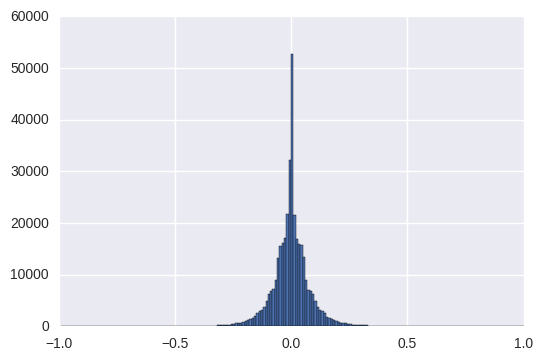

In [32]:
lret.hist(bins=200, range=(-1,1))

In [33]:
print df.head(5)

                         lret                  ts            time_step
ts                                                                    
2012-01-02 02:00:00       NaN 2012-01-02 02:00:00 -9223372036854775808
2012-01-02 02:01:00  0.041918 2012-01-02 02:01:00                   60
2012-01-02 02:02:00  0.009315 2012-01-02 02:02:00                   60
2012-01-02 02:03:00 -0.032602 2012-01-02 02:03:00                   60
2012-01-02 02:04:00  0.046574 2012-01-02 02:04:00                   60


In [34]:
# 1 hour lookback
sequence_length = 20

In [35]:
len(df)

372161

In [36]:
type(lret)

pandas.core.series.Series

In [37]:
steps = df['time_step'][10:70]
(steps == 60).all()

True

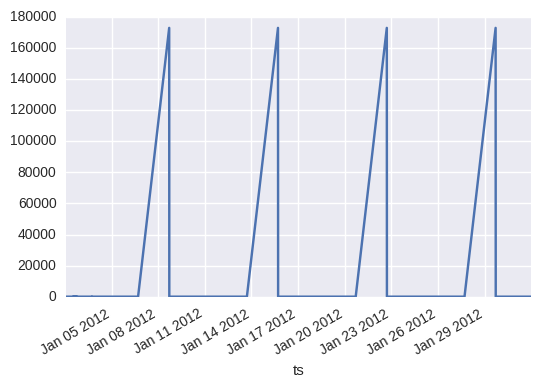

In [38]:
df['time_step']['2012-01'][1:].plot()

In [39]:
# average run length
max_samples = len(lret) - sequence_length
progress = IntProgress(min=0, max=max_samples)
display(progress)
i = 0
rl = 0
results = []
while i < max_samples:
    if df['time_step'][i] == TS_SECS:
        rl += 1
    else:
        results.append(rl)
        while df['time_step'][i] != TS_SECS:
            i+=1
        rl = 0
    i +=1
    if i%1000 == 0:
        progress.value = i

run_length = pd.Series(results)

count     792.000000
mean      467.801768
std       808.677894
min         0.000000
25%        12.750000
50%        64.500000
75%       835.750000
max      7198.000000
dtype: float64

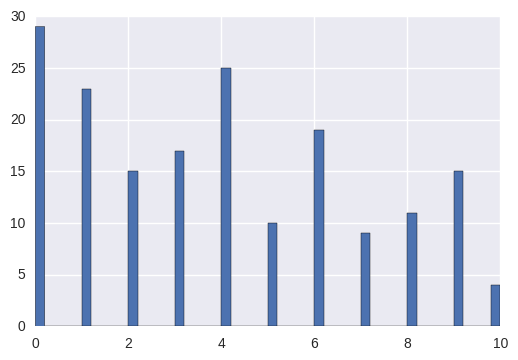

In [40]:
display(run_length.describe())
run_length.hist(bins=50,range=(0,10))


In [41]:
%%time

# construct samples
max_samples = len(lret) - sequence_length

progress = IntProgress(min=0, max=max_samples)
display(progress)

sequences = []
ts_result = []
i = 0
while not (df['time_step'][i:i+sequence_length] == TS_SECS).all():
    i += 1
print "skipped",i
while i < max_samples:   
    steps = df['time_step'][i:i+sequence_length]    
    # only include sequences where all samples have the same step size
    if (steps == TS_SECS).all():
        sequences.append(df['lret'][i: i + sequence_length])
        ts_result.append(df['time_step'][i: i + sequence_length])       

    i += 1
    if i%1000 == 0:
        progress.value = i
sequences = np.array(sequences) 
print sequences.shape

skipped 1
(359008, 20)
CPU times: user 1min 56s, sys: 1.19 s, total: 1min 57s
Wall time: 1min 56s


In [42]:
print len(sequences), max_samples, len(sequences)/ max_samples

359008 372141 0.964709612754


In [43]:
%%time
# sanity check
for r in ts_result:
    if not (r ==60).all():
        print "fail"

CPU times: user 36.9 s, sys: 4 ms, total: 36.9 s
Wall time: 36.9 s


In [44]:
import h5py
with h5py.File('eurusd_2012_sequences_{s}.h5'.format(s=sequence_length), 'w') as f:
    f['sequences'] = sequences

In [45]:
with h5py.File('eurusd_2012_sequences_{s}.h5'.format(s=sequence_length), 'r') as f:
    sequences = f['sequences'][...]

In [46]:
sequences.shape

(359008, 20)

# tests 
Target = 
- sum of sequence. can it learn to add them up..???
- mean of first half of sequence
- mean of first half of sequence minus mean of second half of sequence
( can do this on random data..)